# RSCD Road Surface Classification

This notebook trains an image classifier to predict road-surface classes using the RSCD dataset.
It uses the train split (folders per class) and parses labels from filenames for validation/test.

Notes:
- The full dataset is large; use the `MAX_*_SAMPLES` knobs for quick experiments.
- Pretrained weights require an existing local cache or internet access; set `USE_PRETRAINED` accordingly.


In [6]:
from pathlib import Path
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

DATA_ROOT = Path('data') / 'RSCD dataset-1million'
TRAIN_DIR = DATA_ROOT / 'train'
VAL_DIR = DATA_ROOT / 'vali_20k'
TEST_DIR = DATA_ROOT / 'test_50k'

SEED = 42
BATCH_SIZE = 64
IMAGE_SIZE = 224
NUM_WORKERS = 0
EPOCHS = 3
LR = 3e-4
WEIGHT_DECAY = 1e-4
USE_PRETRAINED = False

MAX_TRAIN_SAMPLES = None  # e.g. 50000 for quick run
MAX_VAL_SAMPLES = None
MAX_TEST_SAMPLES = None

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
device


device(type='cuda')

In [7]:
assert TRAIN_DIR.exists(), f'Missing train directory: {TRAIN_DIR}'
assert VAL_DIR.exists(), f'Missing val directory: {VAL_DIR}'
assert TEST_DIR.exists(), f'Missing test directory: {TEST_DIR}'

class_names = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])
num_classes = len(class_names)
class_names[:10], num_classes


(['dry_asphalt_severe',
  'dry_asphalt_slight',
  'dry_asphalt_smooth',
  'dry_concrete_severe',
  'dry_concrete_slight',
  'dry_concrete_smooth',
  'dry_gravel',
  'dry_mud',
  'fresh_snow',
  'ice'],
 27)

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
class_to_idx = train_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

def parse_label_from_filename(path: Path) -> str:
    stem = path.stem
    if '-' not in stem:
        return stem
    ts, label = stem.split('-', 1)
    return label.replace('-', '_')

class RSCDFlatDataset(Dataset):
    def __init__(self, root_dir: Path, transform=None, class_to_idx=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = sorted([p for p in root_dir.iterdir() if p.is_file()])
        self.class_to_idx = class_to_idx or {}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        label_name = parse_label_from_filename(path)
        if label_name not in self.class_to_idx:
            raise KeyError(f'Label {label_name} not in class_to_idx')
        label = self.class_to_idx[label_name]
        img = datasets.folder.default_loader(path)
        if self.transform:
            img = self.transform(img)
        return img, label

val_ds = RSCDFlatDataset(VAL_DIR, transform=eval_tfms, class_to_idx=class_to_idx)
test_ds = RSCDFlatDataset(TEST_DIR, transform=eval_tfms, class_to_idx=class_to_idx)

len(train_ds), len(val_ds), len(test_ds)


(958941, 19860, 49500)

In [9]:
def maybe_subset(ds, max_samples, seed=42):
    if max_samples is None or max_samples >= len(ds):
        return ds
    rng = np.random.default_rng(seed)
    indices = rng.choice(len(ds), size=max_samples, replace=False)
    return Subset(ds, indices)

train_ds_sub = maybe_subset(train_ds, MAX_TRAIN_SAMPLES, SEED)
val_ds_sub = maybe_subset(val_ds, MAX_VAL_SAMPLES, SEED)
test_ds_sub = maybe_subset(test_ds, MAX_TEST_SAMPLES, SEED)

loader_kwargs = dict(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)
train_loader = DataLoader(train_ds_sub, shuffle=True, **loader_kwargs)
val_loader = DataLoader(val_ds_sub, shuffle=False, **loader_kwargs)
test_loader = DataLoader(test_ds_sub, shuffle=False, **loader_kwargs)

next(iter(train_loader))[0].shape


torch.Size([64, 3, 224, 224])

In [10]:
import time

def time_dataloader(loader, max_batches=5):
    start = time.time()
    for i, _ in enumerate(loader):
        if i + 1 >= max_batches:
            break
    elapsed = time.time() - start
    return elapsed / max_batches

avg_batch_time = time_dataloader(train_loader, max_batches=5)
print(f'Avg train batch load time: {avg_batch_time:.3f}s')
if avg_batch_time > 1.0:
    print('Data loading is slow. Try NUM_WORKERS=0 (Windows), increase BATCH_SIZE, or move data to SSD.')


Avg train batch load time: 0.335s


In [11]:
def build_model(num_classes, use_pretrained=False):
    if use_pretrained:
        weights = models.ResNet18_Weights.DEFAULT
        model = models.resnet18(weights=weights)
    else:
        model = models.resnet18(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

model = build_model(num_classes, USE_PRETRAINED).to(device)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Fast class weights using targets (no image loading)
def compute_class_weights_from_targets(dataset, num_classes):
    if isinstance(dataset, Subset):
        targets = np.array(dataset.dataset.targets)[dataset.indices]
    else:
        targets = np.array(dataset.targets)
    counts = np.bincount(targets, minlength=num_classes)
    counts = np.maximum(counts, 1)
    weights = counts.sum() / counts
    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32)

class_weights = compute_class_weights_from_targets(train_ds_sub, num_classes).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available(), device="cuda")


In [13]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, log_every=100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    for batch_idx, (images, labels) in enumerate(loader, start=1):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        if batch_idx % log_every == 0:
            elapsed = time.time() - start_time
            avg_loss = running_loss / total
            avg_acc = correct / total
            print(f'  [batch {batch_idx}/{len(loader)}] loss {avg_loss:.4f} acc {avg_acc:.4f} | {elapsed:.1f}s elapsed')
    return running_loss / total, correct / total

def evaluate(model, loader, criterion=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        if criterion is not None:
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    acc = correct / total if total else 0
    loss_avg = (running_loss / total) if criterion is not None and total else None
    return loss_avg, acc, all_preds, all_labels


In [14]:
best_val_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    print(f'Epoch {epoch}/{EPOCHS} | train loss {train_loss:.4f} acc {train_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict(), 'class_to_idx': class_to_idx}, 'rscd_resnet18.pt')

best_val_acc


C:\Users\willi\AppData\Local\Temp\ipykernel_42336\3496869272.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


  [batch 100/14984] loss 3.0008 acc 0.2022 | 41.6s elapsed
  [batch 200/14984] loss 2.9020 acc 0.2298 | 81.8s elapsed
  [batch 300/14984] loss 2.8338 acc 0.2480 | 121.6s elapsed
  [batch 400/14984] loss 2.7773 acc 0.2601 | 168.3s elapsed
  [batch 500/14984] loss 2.7347 acc 0.2732 | 210.7s elapsed
  [batch 600/14984] loss 2.6973 acc 0.2839 | 251.6s elapsed
  [batch 700/14984] loss 2.6681 acc 0.2920 | 291.8s elapsed
  [batch 800/14984] loss 2.6389 acc 0.2982 | 332.8s elapsed
  [batch 900/14984] loss 2.6131 acc 0.3042 | 374.7s elapsed
  [batch 1000/14984] loss 2.5913 acc 0.3100 | 414.8s elapsed
  [batch 1100/14984] loss 2.5672 acc 0.3142 | 454.8s elapsed
  [batch 1200/14984] loss 2.5426 acc 0.3201 | 498.9s elapsed
  [batch 1300/14984] loss 2.5193 acc 0.3255 | 542.7s elapsed
  [batch 1400/14984] loss 2.4969 acc 0.3304 | 587.4s elapsed
  [batch 1500/14984] loss 2.4795 acc 0.3340 | 631.4s elapsed
  [batch 1600/14984] loss 2.4600 acc 0.3380 | 675.6s elapsed
  [batch 1700/14984] loss 2.4438 ac

0.7552870090634441

In [15]:
val_loss, val_acc, val_preds, val_labels = evaluate(model, val_loader, criterion)
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f'Val acc: {val_acc:.4f} | Test acc: {test_acc:.4f}')


Val acc: 0.7553 | Test acc: 0.7754
sklearn not available; skipping classification report and confusion matrix.


                       precision    recall  f1-score   support

   dry_asphalt_severe     0.9079    0.5890    0.7145       820
   dry_asphalt_slight     0.7519    0.5951    0.6644       820
   dry_asphalt_smooth     0.6943    0.8585    0.7677       820
  dry_concrete_severe     0.6989    0.7671    0.7314       820
  dry_concrete_slight     0.6435    0.6780    0.6603       820
  dry_concrete_smooth     0.7778    0.7171    0.7462       820
           dry_gravel     0.8362    0.8402    0.8382       820
              dry_mud     0.8817    0.8183    0.8488       820
           fresh_snow     0.9596    0.9280    0.9436       820
                  ice     0.9300    0.9402    0.9351       820
          melted_snow     0.9700    0.9476    0.9587       820
 water_asphalt_severe     0.6989    0.4920    0.5775       250
 water_asphalt_slight     0.6237    0.7841    0.6948       820
 water_asphalt_smooth     0.7988    0.8378    0.8179       820
water_concrete_severe     0.7218    0.5000    0.5908  

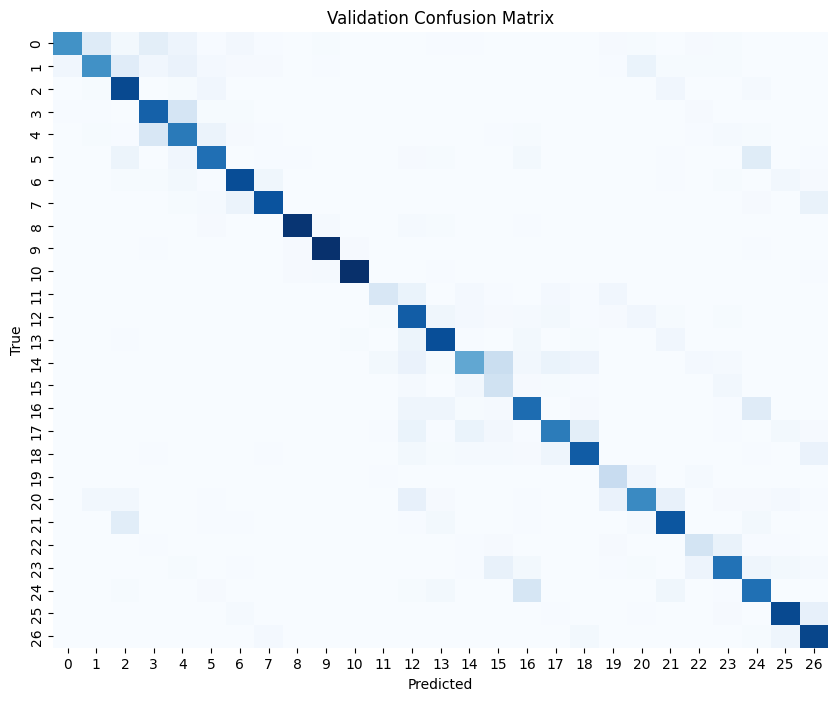

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

report = classification_report(val_labels, val_preds, target_names=class_names, digits=4)
print(report)
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', cbar=False)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
@torch.no_grad()
def predict_one(path: Path):
    img = datasets.folder.default_loader(path)
    x = eval_tfms(img).unsqueeze(0).to(device)
    logits = model(x)
    probs = torch.softmax(logits, dim=1).squeeze(0)
    topk = torch.topk(probs, k=27)
    top_labels = [idx_to_class[i.item()] for i in topk.indices]
    return list(zip(top_labels, topk.values.cpu().tolist()))

# Example
sample_path = "data/RSCD dataset-1million/test_50k/202202081538546-fresh_snow.jpg"
sample_path, predict_one(sample_path)


('data/RSCD dataset-1million/test_50k/202202081538546-fresh_snow.jpg',
 [('fresh_snow', 0.9677878618240356),
  ('ice', 0.03151434659957886),
  ('water_asphalt_smooth', 0.0005124252056702971),
  ('melted_snow', 0.00017793076403904706),
  ('water_mud', 2.4154173843271565e-06),
  ('water_asphalt_slight', 1.6027159972509253e-06),
  ('water_gravel', 1.537419166197651e-06),
  ('water_concrete_severe', 8.874120567270438e-07),
  ('wet_mud', 4.852934125665342e-07),
  ('wet_asphalt_smooth', 1.280747170540053e-07),
  ('dry_asphalt_smooth', 1.0644694015127243e-07),
  ('dry_concrete_slight', 7.9583941214878e-08),
  ('dry_gravel', 5.0435470910770164e-08),
  ('water_concrete_smooth', 4.984255852491515e-08),
  ('water_concrete_slight', 4.6594767155738737e-08),
  ('wet_concrete_smooth', 4.6282803367603265e-08),
  ('dry_concrete_smooth', 3.352742439233225e-08),
  ('wet_gravel', 1.9062367684341552e-08),
  ('wet_concrete_slight', 1.1338974204022634e-08),
  ('water_asphalt_severe', 9.513199117350268e-09),
